In [1]:
import xarray as xr
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import numpy as np
import seaborn as sb
import warnings
from tqdm import tqdm

import multiprocessing as mp

In [2]:
class Variable(object):
    def __init__(
            self,
            varname: str,
            da_mean: xr.DataArray,
            da_mean_hat: xr.DataArray,
            da_var_hat: xr.DataArray | None = None) -> None:

        self.varname = varname
        self.has_var = da_var_hat is not None

        new_ds = xr.Dataset()
        new_ds['obs'] = da_mean
        new_ds['mod'] = da_mean_hat

        if self.has_var:
            new_ds['var'] = da_var_hat

        self.ds = new_ds

        self._da_masked_cached = None

    @property
    def is_hourly(self) -> bool:
        return 'hour' in self.ds.dims

    @property
    def ds_masked(self, recache: bool = False) -> xr.Dataset:
        if self._da_masked_cached is None or recache:
            self._da_masked_cached = self.ds.where(self.ds['obs'].notnull() & self.ds['mod'].notnull()).compute()
        return self._da_masked_cached

    def __repr__(self) -> str:
        s = f'Variable: {self.varname:<10s} | has_var={self.has_var} | is_hourly={self.is_hourly}'
        return s

class Predictions(object):
    def __init__(
            self,
            preds: xr.Dataset,
            cube: xr.Dataset,
            load: bool = False,
            **subset) -> None:
        self.preds = preds.sel(**subset)
        self.has_var = self.check_has_var(ds=self.preds)
        self.cube = cube.sel(**subset)
        self.load = load

        self.daily, self.hourly = self.split_vars(ds=self.preds, cube=self.cube, has_var=self.has_var, load=load)
        self.subset = subset

    @staticmethod
    def check_has_var(ds: xr.Dataset) -> bool:
        mhat_list = [var for var in ds.data_vars if '_hat' in var]
        vhat_list = [var for var in ds.data_vars if '_var_hat' in var]

        if len(vhat_list) > 0 and len(vhat_list) != len(mhat_list):
            raise ValueError(
                'some but not all variables have uncertainty predictions (`_vhat` variable name ending), '
                'which is not allowed. Uncertainties must either be provided for all variables '
                'or for none.'
            )

        return len(vhat_list) > 0

    def split_vars(self, ds: xr.Dataset, cube: xr.Dataset, has_var: bool, load: bool) -> tuple[dict[str, Variable], dict[str, Variable]]:
        daily = {}
        hourly = {}

        for var in list(ds.data_vars):

            is_hourly = 'hour' in ds[var].dims
            var_name, var_desc = var.rsplit('_', 1)

            if '_msc' in var_name:
                #dayofyear = cube.time.dt.dayofyear - 1
                #cube[var_name] = cube[var_name].sel(dayofyear=dayofyear)
                leap_year = ds.time[np.argwhere(ds.time.dt.is_leap_year.values)[0].item()].dt.year.item()
                msc = preds.fvc_msc_hat.sel(time=str(leap_year)).rename({'time': 'dayofyear'})
                msc['dayofyear'] = cube.dayofyear
                ds[var] = msc

            if var_desc == 'hat':
                if self.has_var:
                    ds_var_hat = ds[self._mean_to_vhat_varname(var)]
                else:
                    ds_var_hat = None

                new_var = Variable(
                    varname=var_name,
                    da_mean=self.maybe_load(cube[var_name]),
                    da_mean_hat=self.maybe_load(ds[var]),
                    da_var_hat=self.maybe_load(ds_var_hat)
                )

                if var_name in daily or var_name in hourly:
                    raise KeyError(
                        f'variable {var_name} already exists.'
                    )

                if is_hourly:
                    hourly[var_name] = new_var
                else:
                    daily[var_name] = new_var

        return daily, hourly

    def maybe_load(self, x: xr.Dataset | xr.DataArray | None) -> xr.Dataset | xr.DataArray | None:
        if x is None:
            return x

        if 'dayofyear' in x.dims:
            x = x.chunk({'dayofyear': -1, 'lat': 10, 'lon': -1})
        else:
            x = x.chunk({'time': -1, 'lat': 10, 'lon': -1})
        x = x.where(x.lon > -25, drop=True)

        if self.load:
            return x.load()
        else:
            return x

    def _mean_to_vhat_varname(self, varname: str) -> tuple[str, str]:
        return varname.replace('_hat', '_vhat')

    def __iter__(self) -> tuple[str, Variable]:
        for key, var in self.daily.items():
            yield key, var
        for key, var in self.hourly.items():
            yield key, var
        
        return

    def items(self) -> tuple[str, Variable]:
        yield from iter(self)

    def keys(self) -> str:
        for key, _ in self.daily.items():
            yield key
        for key, _ in self.hourly.items():
            yield key
        
        return

    def values(self) -> Variable:
        for _, var in self.daily.items():
            yield var
        for _, var in self.hourly.items():
            yield var
        
        return

    def __contains__(self, key: str) -> bool:
        if key in self.daily.keys() or key in self.hourly.keys():
            return True
        else:
            return False

    def __getitem__(self, key: str) -> Variable:
        if key in self.daily:
            return self.daily[key]
        elif key in self.hourly:
            return self.hourly[key]
        else:
            raise KeyError(f'key `{key}` not found in variables.')

    @property
    def has_daily(self) -> bool:
        return len(self.daily) > 0

    @property
    def has_hourly(self) -> bool:
        return len(self.hourly) > 0

    def __repr__(self) -> str:
        s = f'VarDict\n{"-" * 20}\n'
        s += ' Variables'
        if len(self.subset) > 0:
            subset = self.subset
            s += f' | {subset=}'
        s += '\n'
        for var in self.daily.values():
            s += f' > {str(var)}\n'
        for var in self.hourly.values():
            s += f' >{str(var)}\n'
        return s

    def plot_mean_ts(self, var: str):
        v = self[var]

        if v.is_hourly:
            raise NotImplementedError()
        if v.has_var:
            raise NotImplementedError()


import matplotlib.pyplot as plt
import numpy as np
from project.utils.geo_plots import subplots_ortho_dense
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

def add_hist(ds, ax, cmap, vmin=None, vmax=None, robust=True, label=None, histogram_placement=[0.04, 0.35, 0.4, 0.3], bins=30, add_contour=True, contour_lw=0.4, **kwargs):

    axh = ax.inset_axes(histogram_placement)

    weights = np.cos(np.deg2rad(ds.lat))

    cmap = plt.get_cmap(cmap)

    data_median = ds.weighted(weights).quantile(0.5).item()
    data_mean = ds.weighted(weights).mean().item()

    weights = weights.expand_dims(lon=ds.lon, axis=1).values

    mask = np.isfinite(ds.values)
    weights = weights[mask]
    ds_data = ds.values[mask]
    
    if vmin is None or vmax is None:
        if robust:
            q = 0.02
        else:
            q = 0.0

        xmin, xmax = np.quantile(ds_data, [q, 1.0-q])

    if vmin is None:
        vmin = xmin
    if vmax is None:
        vmax = xmax

    n, bns, patches = axh.hist(ds_data, bins=np.linspace(vmin, vmax, bins), weights=weights, **kwargs)
    if add_contour:
        axh.hist(ds_data, histtype='step', color='k', bins=bns, lw=contour_lw, weights=weights)

    bin_centers = 0.5 * (bns[:-1] + bns[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cmap(c))

    # axh.hist(ds, weights=cs, bins=bins, color='0.5', range=(vmin, vmax))

    axh.set_title('')
    axh.spines['right'].set_visible(False)
    axh.spines['left'].set_visible(False)
    axh.spines['top'].set_visible(False)
    axh.set_yticks([])
    axh.patch.set_facecolor('None')
    axh.set_xlabel('')

    #min_tick = (vmax - vmin) / (bins - 1) / 2
    #max_tick = vmax - min_tick

    # axh.set_xticks(np.linspace(bin_centers[0], bin_centers[-1], 3))
    # labs = np.linspace(vmin, vmax, 3)
    # labs_new = []
    # for l in labs:
    #     if l % 1 == 0:
    #         labs_new.append(int(l))
    #     else:
    #         labs_new.append(l)

    #axh.set_xticklabels(labs_new)
    axh.xaxis.set_tick_params(labelsize=9, pad=0.2)
    axh.axvline(data_mean, color='0.3', lw=1.2)
    axh.axvline(data_median, color='0.3', ls=':', lw=1.2)

    if label is not None:
        axh.set_xlabel(label, fontsize=9)

    axh.text(
        0.02, 0.2,
        'Area-weighted distribution\nof map values with mean ({0})\nand median ({1}).'.format(u'\u2500', u'\u2509'),
        ha='left',
        va='top',
        transform=ax.transAxes,
        fontsize=9,
        style='italic'
    )

def plot_map(ds, label, title=None, vmin=None, vmax=None, robust=True, cmap='coolwarm', do_center=False):

    fig, axes = subplots_ortho_dense()

    plot_kwargs = {}

    if do_center:
        plot_kwargs.update(center=0)


    ds.plot(ax=axes[0], transform=ccrs.PlateCarree(), add_colorbar=False, cmap=cmap, robust=robust, vmin=vmin, vmax=vmax, **plot_kwargs)
    ds.plot(ax=axes[1], transform=ccrs.PlateCarree(), add_colorbar=False, cmap=cmap, robust=robust, vmin=vmin, vmax=vmax, **plot_kwargs)

    for ax in axes:
        ax.set_title('')

    if title is not None:
        axes[1].text(
            0.22, 0.74,
            title,
            ha='center',
            va='top',
            transform=ax.transAxes,
            fontsize=9
        )

    add_hist(ds, ax=axes[1], cmap=cmap, label=label, vmin=vmin, vmax=vmax, robust=robust)

    gridline_spec = dict(
        linewidth=0.7,
        color='k',
        alpha=0.7,
        linestyle='--'
    )

    for lon in [0, 30, 60]:
        axes[0].plot([lon, lon], [-30, 80], transform=ccrs.PlateCarree(), **gridline_spec)

    for lat in [45, 60]:
        axes[0].plot([-12, 90], [lat, lat], transform=ccrs.PlateCarree(), **gridline_spec)

    for lon in [0, 30, 60]:
        lat_min = -40 if lon == 30 else 5
        axes[1].plot([lon, lon], [lat_min, 80], transform=ccrs.PlateCarree(), **gridline_spec)

    for lat, (lon_min, lon_max) in zip([-30, -15, 0, 15], [(14, 35), (10, 55), (8, 46), (-30, 55)]):
        axes[1].plot([lon_min, lon_max], [lat, lat], transform=ccrs.PlateCarree(), **gridline_spec)


    return fig, axes

def plot_ts(var, lat=None, lon=None, figsize=(10, 4), add_legend=True, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    lat_lon_sel = {}

    if lat is not None:
        lat_lon_sel.update({'lat': lat})
    if lon is not None:
        lat_lon_sel.update({'lon': lon})

    ds_sel = var.ds_masked.sel(**lat_lon_sel)

    lat_lon_mean_dims = []
    if 'lat' in ds_sel.dims:
        lat_lon_mean_dims.append('lat')
    if 'lon' in ds_sel.dims:
        lat_lon_mean_dims.append('lon')
    if len(lat_lon_mean_dims) > 0:
        ds_sel = ds_sel.mean(lat_lon_mean_dims).compute()

    ds_sel.obs.plot(label='observed', ax=ax, color='k', **kwargs)
    ds_sel.mod.plot(label='predicted', ax=ax, color='tab:orange', alpha=0.9, **kwargs)
    if add_legend:
        ax.legend()

In [3]:
def calculate_corr(ds, dim='time'):

    valid_values = (ds['mod'].notnull() & ds['obs'].notnull()).compute()
    valid_count = valid_values.sum(dim).compute()

    demeaned_pred = (ds['mod'] - ds['mod'].mean(dim)).fillna(0)
    demeaned_obs = (ds['obs'] - ds['obs'].mean(dim)).fillna(0)

    cov = (xr.dot(demeaned_pred, demeaned_obs, dims=dim) / valid_count).compute()

    del demeaned_pred
    del demeaned_obs

    pred_std = ds['mod'].std(dim).compute()
    obs_std = ds['obs'].std(dim).compute()

    corr = cov / (pred_std * obs_std)

    return corr

def calculate_nnse(ds, dim='time'):
    se = ((ds['mod'] - ds['obs']) ** 2).sum(dim).compute()
    so = ((ds['obs'] - ds['obs'].mean(dim)) ** 2).sum(dim).compute()
    nse = (1 - se / so).compute()
    del se
    del so
    nnse = 1 / (2 - nse)
    return nnse.compute()

In [4]:
cmap_div = sb.diverging_palette(20, 220, sep=1, as_cmap=True) # sb.diverging_palette(20, 220, sep=10, as_cmap=True)
cmap_cont = 'plasma'


In [5]:
cube = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')
preds = xr.open_zarr('/Net/Groups/BGI/people/bkraft/drought_ml/experiments/default/exp_00_2023-03-03_12-35-20/cv/predictions.zarr/')

In [6]:
%%time

vd = Predictions(preds=preds, cube=cube, load=True, time=slice('2004', '2019'))
vd

CPU times: user 10min 55s, sys: 1min 46s, total: 12min 41s
Wall time: 5min 19s


VarDict
--------------------
 Variables | subset={'time': slice('2004', '2019', None)}
 > Variable: fvc_ano    | has_var=False | is_hourly=False
 > Variable: fvc_msc    | has_var=False | is_hourly=False

In [7]:
var = vd['fvc_ano']
var

Variable: fvc_ano    | has_var=False | is_hourly=False

In [8]:
%%time

with warnings.catch_warnings(record=True):
    nnse = xr.map_blocks(calculate_nnse, var.ds_masked.chunk({'time': -1, 'lat': 20, 'lon': 20}), template=var.ds.obs.isel(time=0).drop('time').chunk({'lat': 20, 'lon': 20})).compute()
    corr = xr.map_blocks(calculate_corr, var.ds_masked.chunk({'time': -1, 'lat': 20, 'lon': 20}), template=var.ds.obs.isel(time=0).drop('time').chunk({'lat': 20, 'lon': 20})).compute()

CPU times: user 16min 7s, sys: 21.8 s, total: 16min 29s
Wall time: 4min 35s


(<Figure size 400x540 with 2 Axes>,
 [<GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
  <GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>])

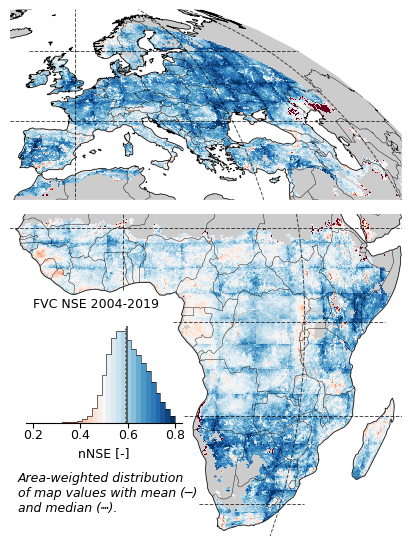

In [9]:
plot_map(
    nnse,
    label='nNSE [-]',
    title='FVC NSE 2004-2019',
    cmap='RdBu',
    vmin=0.2,
    vmax=0.8,
    do_center=False
)

(<Figure size 400x540 with 2 Axes>,
 [<GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
  <GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>])

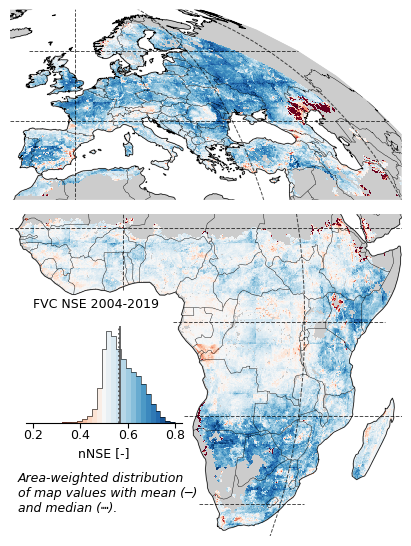

In [59]:
plot_map(
    nnse,
    label='nNSE [-]',
    title='FVC NSE 2004-2019',
    cmap='RdBu',
    vmin=0.2,
    vmax=0.8,
    do_center=False
)

(<Figure size 400x540 with 2 Axes>,
 [<GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
  <GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>])

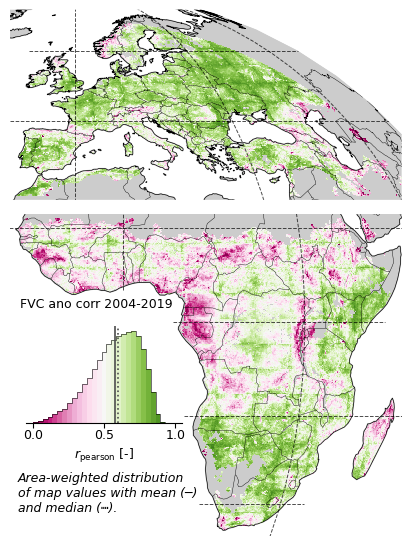

In [12]:
plot_map(
    corr,
    label='$r_\mathrm{pearson}$ [-]',
    title='FVC ano corr 2004-2019',
    cmap='PiYG',
    vmin=0.0,
    vmax=1.0,
    do_center=True
)

In [13]:
class MaskLayout(object):
    def __init__(self, mask: xr.DataArray, lat_block_size=40, lon_block_size=60):
        self.mask = mask.load()
        self.lat_block_size = lat_block_size
        self.lon_block_size = lon_block_size

        coarse_mask = (self.mask.coarsen(lat=self.lat_block_size, lon=self.lon_block_size, boundary='trim').sum() > 500).compute()
        self.coords = np.argwhere(coarse_mask.values)

    def __getitem__(self, idx: int) -> tuple[slice, slice]:
        if idx >= len(self):
            raise ValueError(
                f'index `{idx}` out of bounds.'
            )

        lat_idx, lon_idx = self.coords[idx]
    
        lat_start = self.ind2coord(lat_idx * self.lat_block_size, which='lat')
        lat_stop = self.ind2coord((lat_idx  +1 ) * self.lat_block_size, which='lat')
        lon_start = self.ind2coord(lon_idx * self.lon_block_size, which='lon')
        lon_stop = self.ind2coord((lon_idx  +1 ) * self.lon_block_size, which='lon')

        lat_slice = slice(lat_start, lat_stop)
        lon_slice = slice(lon_start, lon_stop)

        return lat_slice, lon_slice

    def ind2coord(self, idx: int, which: str) -> float:
        if which == 'lat':
            coords = self.mask.lat
        elif which == 'lon':
            coords = self.mask.lon
        else:
            raise ValueError(
                f'`which` must be one `lat` or `lon`, is {which}.'
            )

        if idx > len(coords):
            idx = len(coords) - 1

        return coords[idx].item()

    def __len__(self) -> int:
        return len(self.coords)

    def __iter__(self):
        for idx in range(len(self)):
            yield self[idx]

    def plot_ts(self, idx: int, ax=None, **kwargs):
        lat_slice, lon_slice = self[idx]
        plot_ts(var, lat=lat_slice, lon=lon_slice, ax=ax, **kwargs)

    def plot_layout(self, label: str | None = None, x: xr.DataArray | None = None, **kwargs):
        if x is None:
            fig, axes = subplots_ortho_dense()
        else:
            fig, axes = plot_map(
                x,
                label=label,
                **kwargs
            )

        for i, (lat, lon) in enumerate(self):
            if lat.start > 20:
                ax = axes[0]
            else:
                ax = axes[1]

            ax.plot(
                [lon.start, lon.stop, lon.stop, lon.start, lon.start],
                [lat.start, lat.start, lat.stop, lat.stop, lat.start],
                transform=ccrs.PlateCarree(),
                color='black', lw=0.8
                #path_effects=[patheffects.withStroke(linewidth=2, foreground='white', capstyle='round')]
            )
            ax.text(
                (lon.stop + lon.start) / 2,
                (lat.stop + lat.start) / 2,
                i,transform=ccrs.PlateCarree(), ha='center', va='center',
                color='white', zorder=999,
                path_effects=[patheffects.withStroke(linewidth=2, foreground='black', capstyle='round')])

In [14]:
m = MaskLayout(cube.fold_mask.isin([4]))

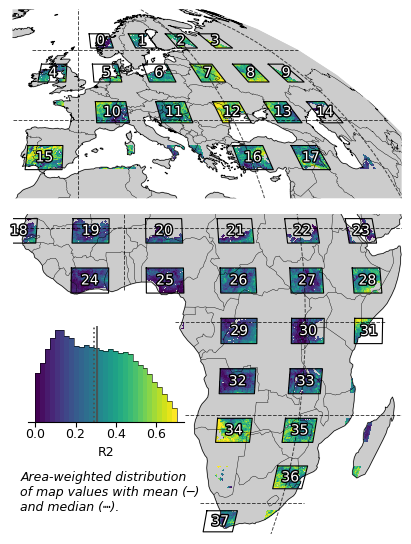

In [15]:
m.plot_layout('R2', corr.where(cube.fold_mask.isin([4])).load() ** 2, vmin=0, vmax=0.7, cmap='viridis')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:19<00:00,  1.48s/it]


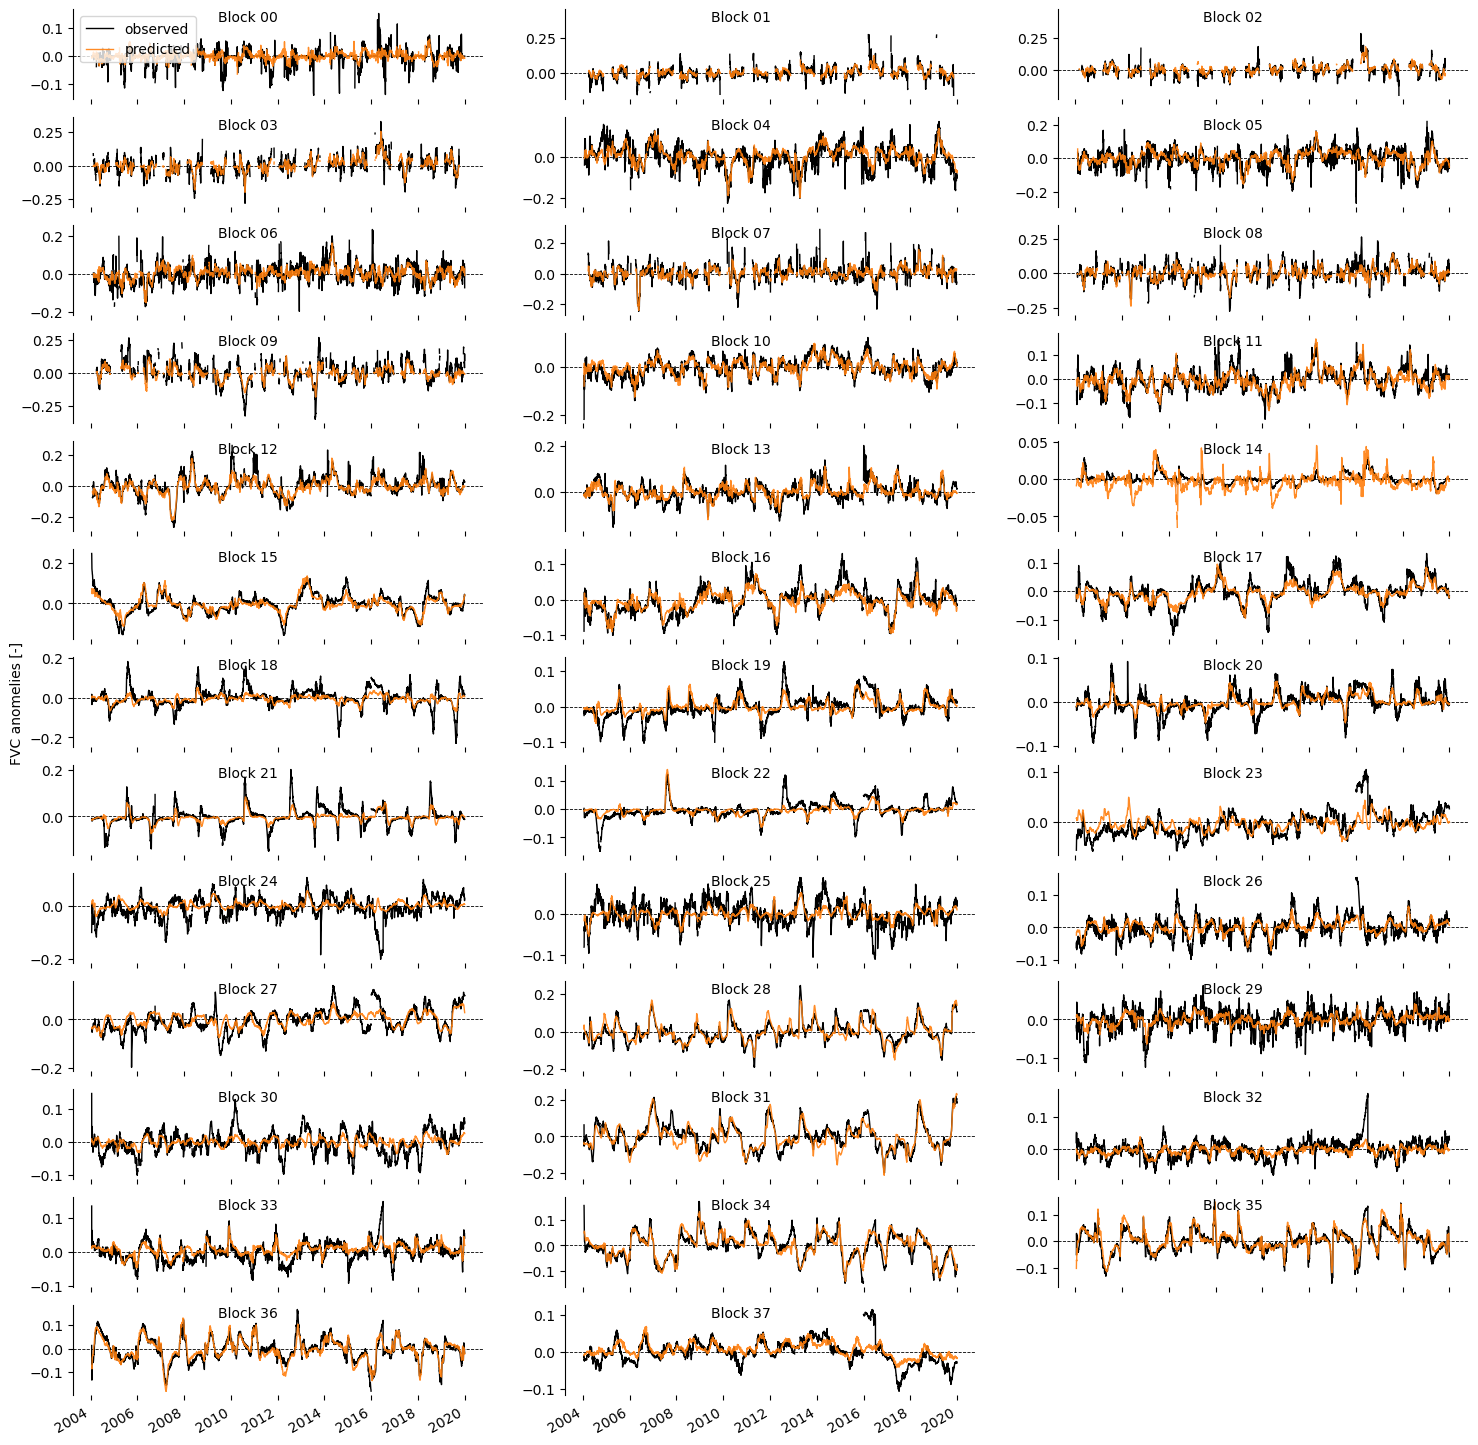

In [16]:
fig, axes = plt.subplots(13, 3, figsize=(18, 18), sharex=True, sharey=False)

c = -1
for i in tqdm(range(axes.shape[0])):
    for j in range(axes.shape[1]):
        c += 1
        ax = axes[i, j]
        ax.spines[['right', 'top', 'bottom']].set_visible(False)
        ax.axhline(0, lw=0.6, ls='--', color='k', zorder=-999)
        
        try:
            m.plot_ts(c, ax=ax, add_legend=c==0, lw=1.0)
        except ValueError as e:
            ax.remove()

        if i == axes.shape[0] // 2 and j == 0:
            ax.set_ylabel('FVC anomelies [-]')
        else:
            ax.set_ylabel('')

        ax.set_xlabel('')

        ax.text(0.5, 0.99, f'Block {c:02d}', transform=ax.transAxes, ha='right', va='top')


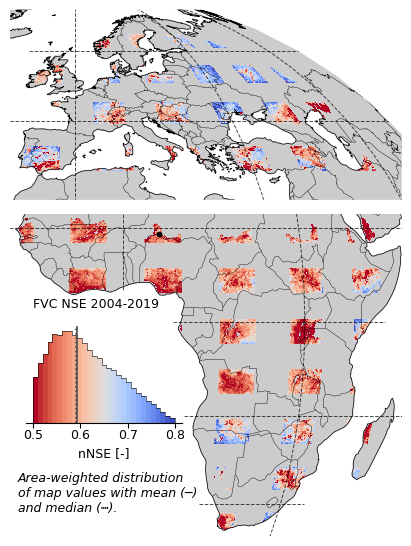

In [13]:
fig, axes = plot_map(
    nnse.where(cube.fold_mask.isin([4])).load(),
    label='nNSE [-]',
    title='FVC NSE 2004-2019',
    cmap='coolwarm_r',
    vmin=0.5,
    vmax=0.8,
    do_center=False
)

lon = 6
lat = 14

axes[1].scatter(
    lon, lat,
    transform=ccrs.PlateCarree(),
    color='black',
    s=10
)

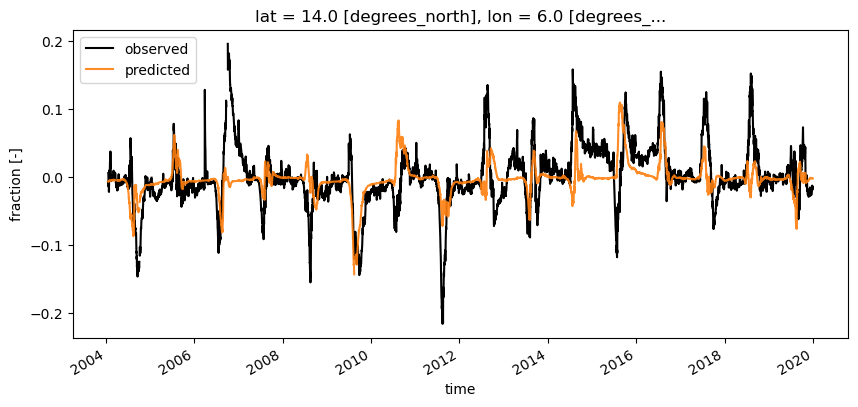

In [14]:
plot_ts(var, lat=lat, lon=lon)

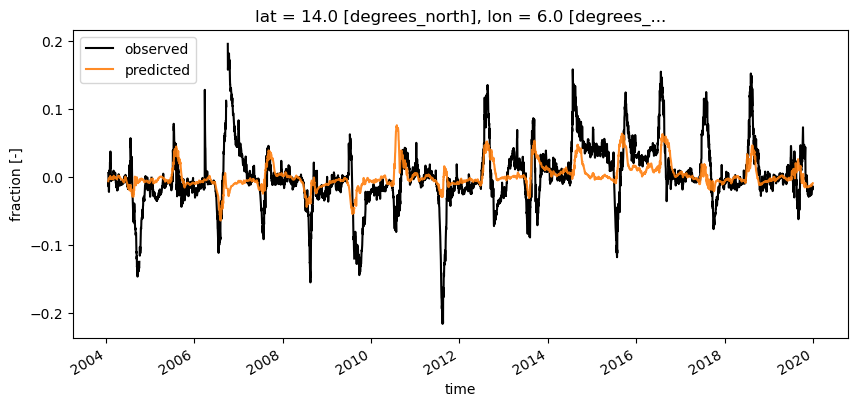

In [18]:
plot_ts(var, lat=lat, lon=lon)

(<Figure size 400x540 with 2 Axes>,
 [<GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
  <GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>])

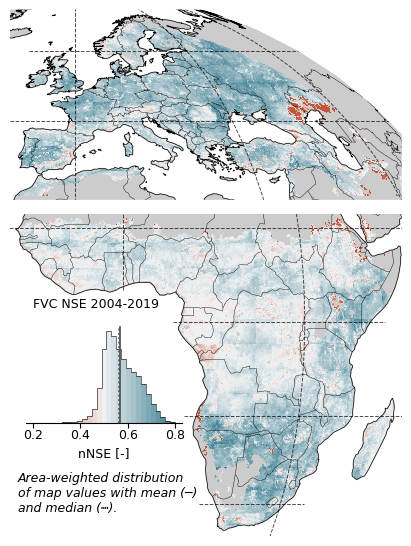

In [20]:
plot_map(
    nnse,
    label='nNSE [-]',
    title='FVC NSE 2004-2019',
    cmap=cmap_div,
    vmin=0.2,
    vmax=0.8,
    do_center=False
)

In [31]:
diff = (var.ds_masked.mod - var.ds_masked.obs).compute()

In [ ]:
d = xr.Dataset()
d['obs'] = diff.isel(time=slice(1, None)).assign_coords(time=diff.isel(time=slice(0, -1)).time)
d['mod'] = diff.isel(time=slice(0, -1))

d_corr = xr.map_blocks(calculate_corr, d.chunk({'time': -1, 'lat': 20, 'lon': 20}), template=var.ds.obs.isel(time=0).drop('time').chunk({'lat': 20, 'lon': 20})).compute()

(<Figure size 400x540 with 2 Axes>,
 [<GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
  <GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>])

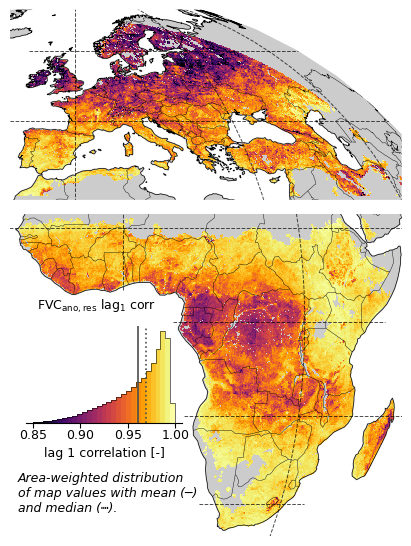

In [55]:
plot_map(
    d_corr,
    label='lag 1 correlation [-]',
    title=r'FVC$_\mathrm{ano, res}$ lag$_1$ corr',
    cmap='inferno',
    vmin=0.85,
    vmax=1.0,
    do_center=False
)